In [31]:
import pandas as pd
des=pd.read_csv("/content/description.txt")
des.head()

,Train data:
0,ID ::: TITLE ::: GENRE ::: DESCRIPTION
1,ID ::: TITLE ::: GENRE ::: DESCRIPTION
2,ID ::: TITLE ::: GENRE ::: DESCRIPTION
3,ID ::: TITLE ::: GENRE ::: DESCRIPTION
4,Test data:


**preprocessing function :**

In [32]:
def load_and_parse_data(filepath, has_genre=True):
    data = []
    with open(filepath, 'r') as file:
        for line in file:
            parts = line.strip().split(' ::: ')
            if has_genre:
                if len(parts) == 4:
                    data.append(parts)
            else:
                if len(parts) == 3:
                    data.append(parts)

    columns = ['ID', 'Title', 'Genre', 'Plot'] if has_genre else ['ID', 'Title', 'Plot']
    return pd.DataFrame(data, columns=columns)

train = load_and_parse_data("/content/train_data.txt", has_genre=True)
test = load_and_parse_data("/content/test_data.txt", has_genre=False)
test_solution = load_and_parse_data("/content/test_data_solution.txt", has_genre=True)

train.head()
test.head()
test_solution.head()

,ID,Title,Genre,Plot
0,1,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apart..."
1,2,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty chi..."
2,3,Off the Beaten Track (2010),documentary,One year in the life of Albin and his family o...
3,4,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with his..."
4,5,Er nu zhai (1955),drama,Before he was known internationally as a marti...


**DATA PREPROCESSING :**

In [33]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d', ' ', text)

    text = re.sub(r'\s+[a-z]\s+', ' ', text)

    text = re.sub(r'\s+', ' ', text)
    return text

print("Train data columns:", train.columns)
print("Test data columns:", test.columns)


Train data columns: Index(['ID', 'Title', 'Genre', 'Plot'], dtype='object')
Test data columns: Index(['ID', 'Title', 'Plot'], dtype='object')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**FEATURE EXTRACTION :**

In [34]:
train['processed_plot'] = train['Plot'].apply(preprocess_text)
test['processed_plot'] = test['Plot'].apply(preprocess_text)

X_train = train['processed_plot']
y_train = train['Genre']
X_test = test['processed_plot']
y_test = test_solution['Genre']

**MODEL SELECTION AND TRAINING :**

In [35]:
print("First few rows of test dataset:")
print(test.head())

print("\nFirst few rows of test_solution dataset:")
print(test_solution.head())


First few rows of test dataset:
  ID                        Title  \
0  1         Edgar's Lunch (1998)   
1  2     La guerra de papá (1977)   
2  3  Off the Beaten Track (2010)   
3  4       Meu Amigo Hindu (2015)   
4  5            Er nu zhai (1955)   

                                                Plot  \
0  L.R. Brane loves his life - his car, his apart...   
1  Spain, March 1964: Quico is a very naughty chi...   
2  One year in the life of Albin and his family o...   
3  His father has died, he hasn't spoken with his...   
4  Before he was known internationally as a marti...   

                                      processed_plot  
0  l brane loves his life his car his apartment h...  
1  spain march quico is very naughty child of thr...  
2  one year in the life of albin and his family o...  
3  his father has died he hasn spoken with his br...  
4  before he was known internationally as martial...  

First few rows of test_solution dataset:
  ID                        Title   

In [36]:
print(f'Number of samples in test: {len(X_test)}')
print(f'Number of samples in test_solution: {len(y_test)}')

aligned_test = test[test['ID'].isin(test_solution['ID'])]
aligned_test_solution = test_solution[test_solution['ID'].isin(test['ID'])]

print(f'Number of samples in aligned_test: {len(aligned_test)}')
print(f'Number of samples in aligned_test_solution: {len(aligned_test_solution)}')

if len(aligned_test) != len(aligned_test_solution):
    raise ValueError("Mismatch still exists in the number of samples after alignment.")

aligned_X_test = aligned_test['processed_plot']
aligned_y_test = aligned_test_solution['Genre']

tfidf_vect = TfidfVectorizer(max_features=5000, stop_words=stopwords.words('english'))

X_train_tfidf = tfidf_vect.fit_transform(X_train)
aligned_X_test_tfidf = tfidf_vect.transform(aligned_X_test)

Number of samples in test: 11520
Number of samples in test_solution: 11303
Number of samples in aligned_test: 11303
Number of samples in aligned_test_solution: 11303


In [43]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

**Logistic Regression :**

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)
y_pred_lr = lr_model.predict(aligned_X_test_tfidf)
print(f'Logistic Regression Accuracy: {accuracy_score(aligned_y_test, y_pred_lr)}')
print(classification_report(aligned_y_test, y_pred_lr))

Logistic Regression Accuracy: 0.5341944616473503


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      action       0.57      0.07      0.13       283
       adult       0.42      0.04      0.07       122
   adventure       0.50      0.02      0.04       144
   animation       0.00      0.00      0.00       123
   biography       0.00      0.00      0.00        54
      comedy       0.46      0.50      0.48      1541
       crime       0.00      0.00      0.00        89
 documentary       0.60      0.87      0.71      2737
       drama       0.49      0.79      0.61      2873
      family       1.00      0.01      0.02       171
     fantasy       0.00      0.00      0.00        61
   game-show       1.00      0.18      0.30        39
     history       0.00      0.00      0.00        51
      horror       0.70      0.40      0.51       456
       music       0.78      0.19      0.31       161
     musical       0.00      0.00      0.00        45
     mystery       0.00      0.00      0.00        64
        news       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


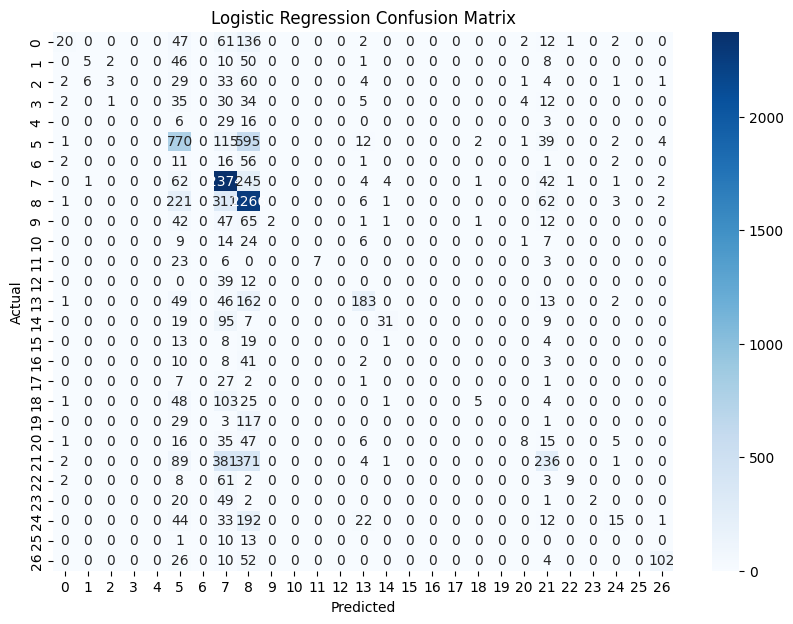

In [30]:
plot_confusion_matrix(aligned_y_test, y_pred_lr, 'Logistic Regression Confusion Matrix')

**NAVIE BAYES :**

In [39]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb = nb_model.predict(aligned_X_test_tfidf)
print(f'Naive Bayes Accuracy: {accuracy_score(aligned_y_test, y_pred_nb)}')
print(classification_report(aligned_y_test, y_pred_nb))

Naive Bayes Accuracy: 0.47792621427939486


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      action       0.29      0.01      0.01       283
       adult       0.00      0.00      0.00       122
   adventure       0.00      0.00      0.00       144
   animation       0.00      0.00      0.00       123
   biography       0.00      0.00      0.00        54
      comedy       0.51      0.30      0.38      1541
       crime       0.00      0.00      0.00        89
 documentary       0.55      0.88      0.67      2737
       drama       0.42      0.85      0.56      2873
      family       0.00      0.00      0.00       171
     fantasy       0.00      0.00      0.00        61
   game-show       0.00      0.00      0.00        39
     history       0.00      0.00      0.00        51
      horror       0.90      0.06      0.11       456
       music       0.00      0.00      0.00       161
     musical       0.00      0.00      0.00        45
     mystery       0.00      0.00      0.00        64
        news       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


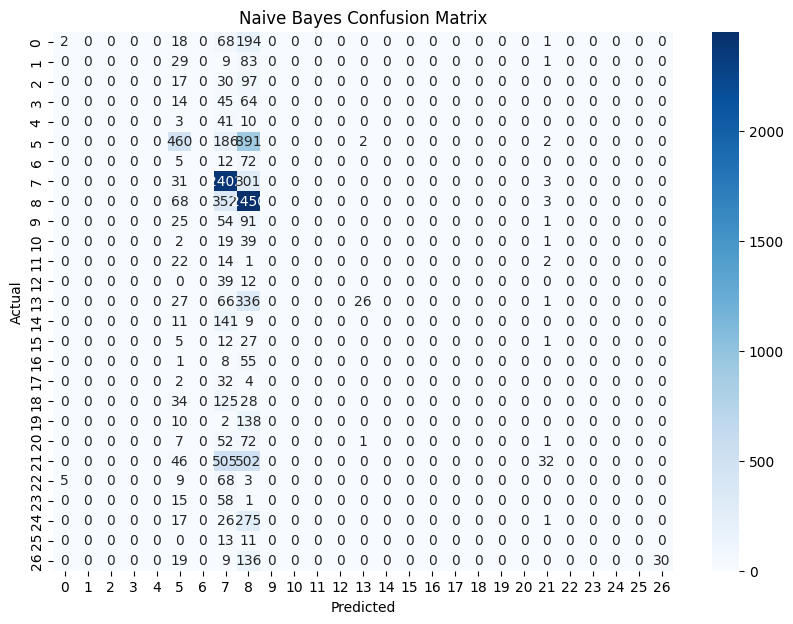

In [40]:
plot_confusion_matrix(aligned_y_test, y_pred_nb, 'Naive Bayes Confusion Matrix')

**SUPPORT VECTOR MACHINE (SVM) :**

In [42]:
from sklearn.svm import SVC

svm_model = SVC(kernel='linear')
svm_model.fit(X_train_tfidf, y_train)
y_pred_svm = svm_model.predict(aligned_X_test_tfidf)
print(f'SVM Accuracy: {accuracy_score(aligned_y_test, y_pred_svm)}')
print(classification_report(aligned_y_test, y_pred_svm))

SVM Accuracy: 0.5490577722728479


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      action       0.49      0.19      0.27       283
       adult       0.50      0.15      0.23       122
   adventure       0.58      0.18      0.28       144
   animation       0.60      0.02      0.05       123
   biography       0.00      0.00      0.00        54
      comedy       0.46      0.52      0.49      1541
       crime       0.00      0.00      0.00        89
 documentary       0.64      0.84      0.72      2737
       drama       0.50      0.76      0.61      2873
      family       0.75      0.05      0.10       171
     fantasy       0.00      0.00      0.00        61
   game-show       0.83      0.49      0.61        39
     history       0.00      0.00      0.00        51
      horror       0.65      0.49      0.56       456
       music       0.62      0.36      0.46       161
     musical       0.00      0.00      0.00        45
     mystery       0.00      0.00      0.00        64
        news       0.75    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


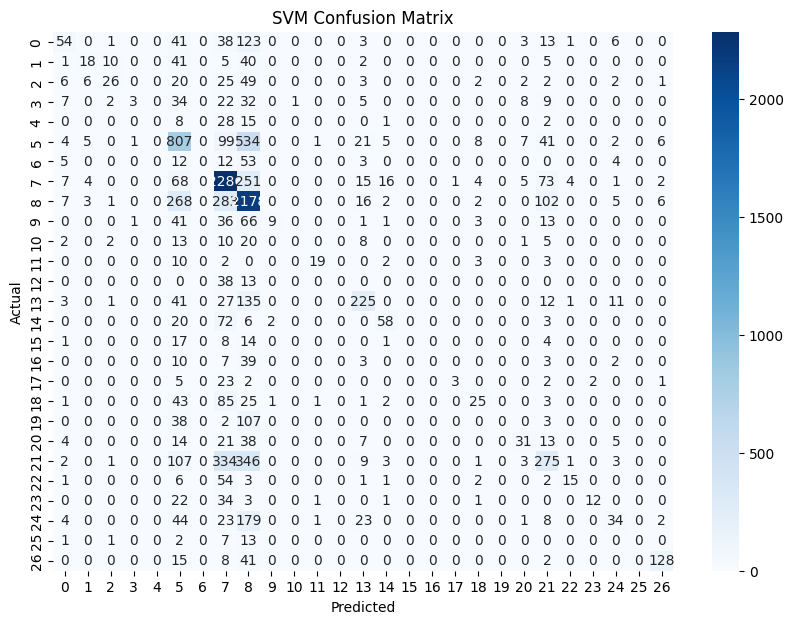

In [41]:
plot_confusion_matrix(aligned_y_test, y_pred_svm, 'SVM Confusion Matrix')

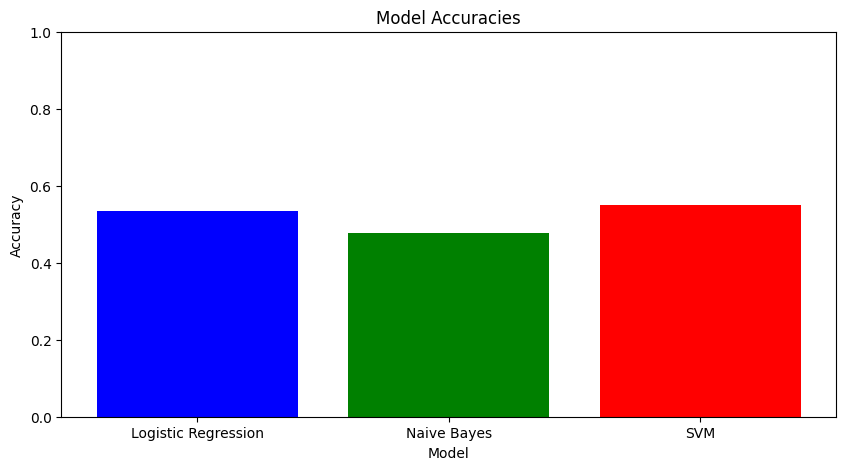

In [29]:
def plot_accuracy_bar(accuracies):
    plt.figure(figsize=(10, 5))
    plt.bar(accuracies.keys(), accuracies.values(), color=['blue', 'green', 'red'])
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracies')
    plt.ylim(0, 1)
    plt.show()

accuracies = {
    'Logistic Regression': accuracy_score(aligned_y_test, y_pred_lr),
    'Naive Bayes': accuracy_score(aligned_y_test, y_pred_nb),
    'SVM': accuracy_score(aligned_y_test, y_pred_svm)
}
plot_accuracy_bar(accuracies)